In [15]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest

# model imports
from sklearn.linear_model import LogisticRegression #linear model
from sklearn.svm import SVC # support vector machine
from sklearn.ensemble import RandomForestClassifier #ensemble model
from sklearn.tree import DecisionTreeClassifier # decision tree model


from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 100


# Import Dataset

Dataset Details

This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default. 

link to dataset: https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

Variables Name



In [2]:
df =  pd.read_csv('../data/default_credit_dataset.csv', sep=';', dtype=str)

## Data Understanding and Preprocessing

In [3]:
df.sample(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
13907,13908,20000,1,2,1,36,0,0,0,0,0,0,20710,21790,21017,19772,15628,12501,1739,1453,691,512,1430,0,0
25674,25675,30000,2,2,1,39,-1,-1,-1,-1,-1,-1,4042,5060,2300,0,780,0,5327,2300,0,780,0,0,0
19583,19584,360000,2,2,1,36,0,0,0,0,0,0,16557,18369,20067,48307,12918,12375,3000,2000,29079,1066,1000,1000,0
12867,12868,20000,1,3,2,40,0,0,2,0,0,-2,5945,8184,7839,7999,0,0,2345,0,160,0,0,0,1
24624,24625,30000,1,1,2,31,-1,-1,0,0,-1,-1,6456,4390,3016,4504,5755,3560,4398,3000,3009,5767,3566,26444,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  object
 1   LIMIT_BAL                   30000 non-null  object
 2   SEX                         30000 non-null  object
 3   EDUCATION                   30000 non-null  object
 4   MARRIAGE                    30000 non-null  object
 5   AGE                         30000 non-null  object
 6   PAY_0                       30000 non-null  object
 7   PAY_2                       30000 non-null  object
 8   PAY_3                       30000 non-null  object
 9   PAY_4                       30000 non-null  object
 10  PAY_5                       30000 non-null  object
 11  PAY_6                       30000 non-null  object
 12  BILL_AMT1                   30000 non-null  object
 13  BILL_AMT2                   30000 non-null  ob

In [5]:
# renaming column
df.rename(columns={'default payment next month': 'default'}, inplace=True)

As there are no empty values in the dataset, we can proceed to the next step.

In [6]:
df.groupby('default')['default'].value_counts()

default
0    23364
1     6636
Name: count, dtype: int64

In [7]:
df.groupby('default')['default'].value_counts()/len(df)

default
0    0.7788
1    0.2212
Name: count, dtype: float64

The class is imbalance with majority of classes is non default, only 22% is identified as default

### Transform Data

In [8]:
for col in [col for col in df.columns if ('PAY_' in col) or (col.startswith('AGE')) or ('BILL' in col) or ('LIMIT' in col) or ('default' in col)]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

## Define data type for features and target

In [9]:
target = 'default'

numeric_features = [
    'LIMIT_BAL', 
    'AGE',
    'PAY_0', 
    'PAY_2', 
    'PAY_3',
    'PAY_4', 
    'PAY_5', 
    'PAY_6',
    'BILL_AMT1', 
    'BILL_AMT2', 
    'BILL_AMT3',
    'BILL_AMT4', 
    'BILL_AMT5', 
    'BILL_AMT6', 
    'PAY_AMT1', 
    'PAY_AMT2',
    'PAY_AMT3', 
    'PAY_AMT4', 
    'PAY_AMT5', 
    'PAY_AMT6'
]

categorical_features = [
    'SEX', 'EDUCATION', 'MARRIAGE'
]

In [10]:
# drop unused columns
df = df[categorical_features + numeric_features + [target]].copy()

## Exploratory Data Analysis

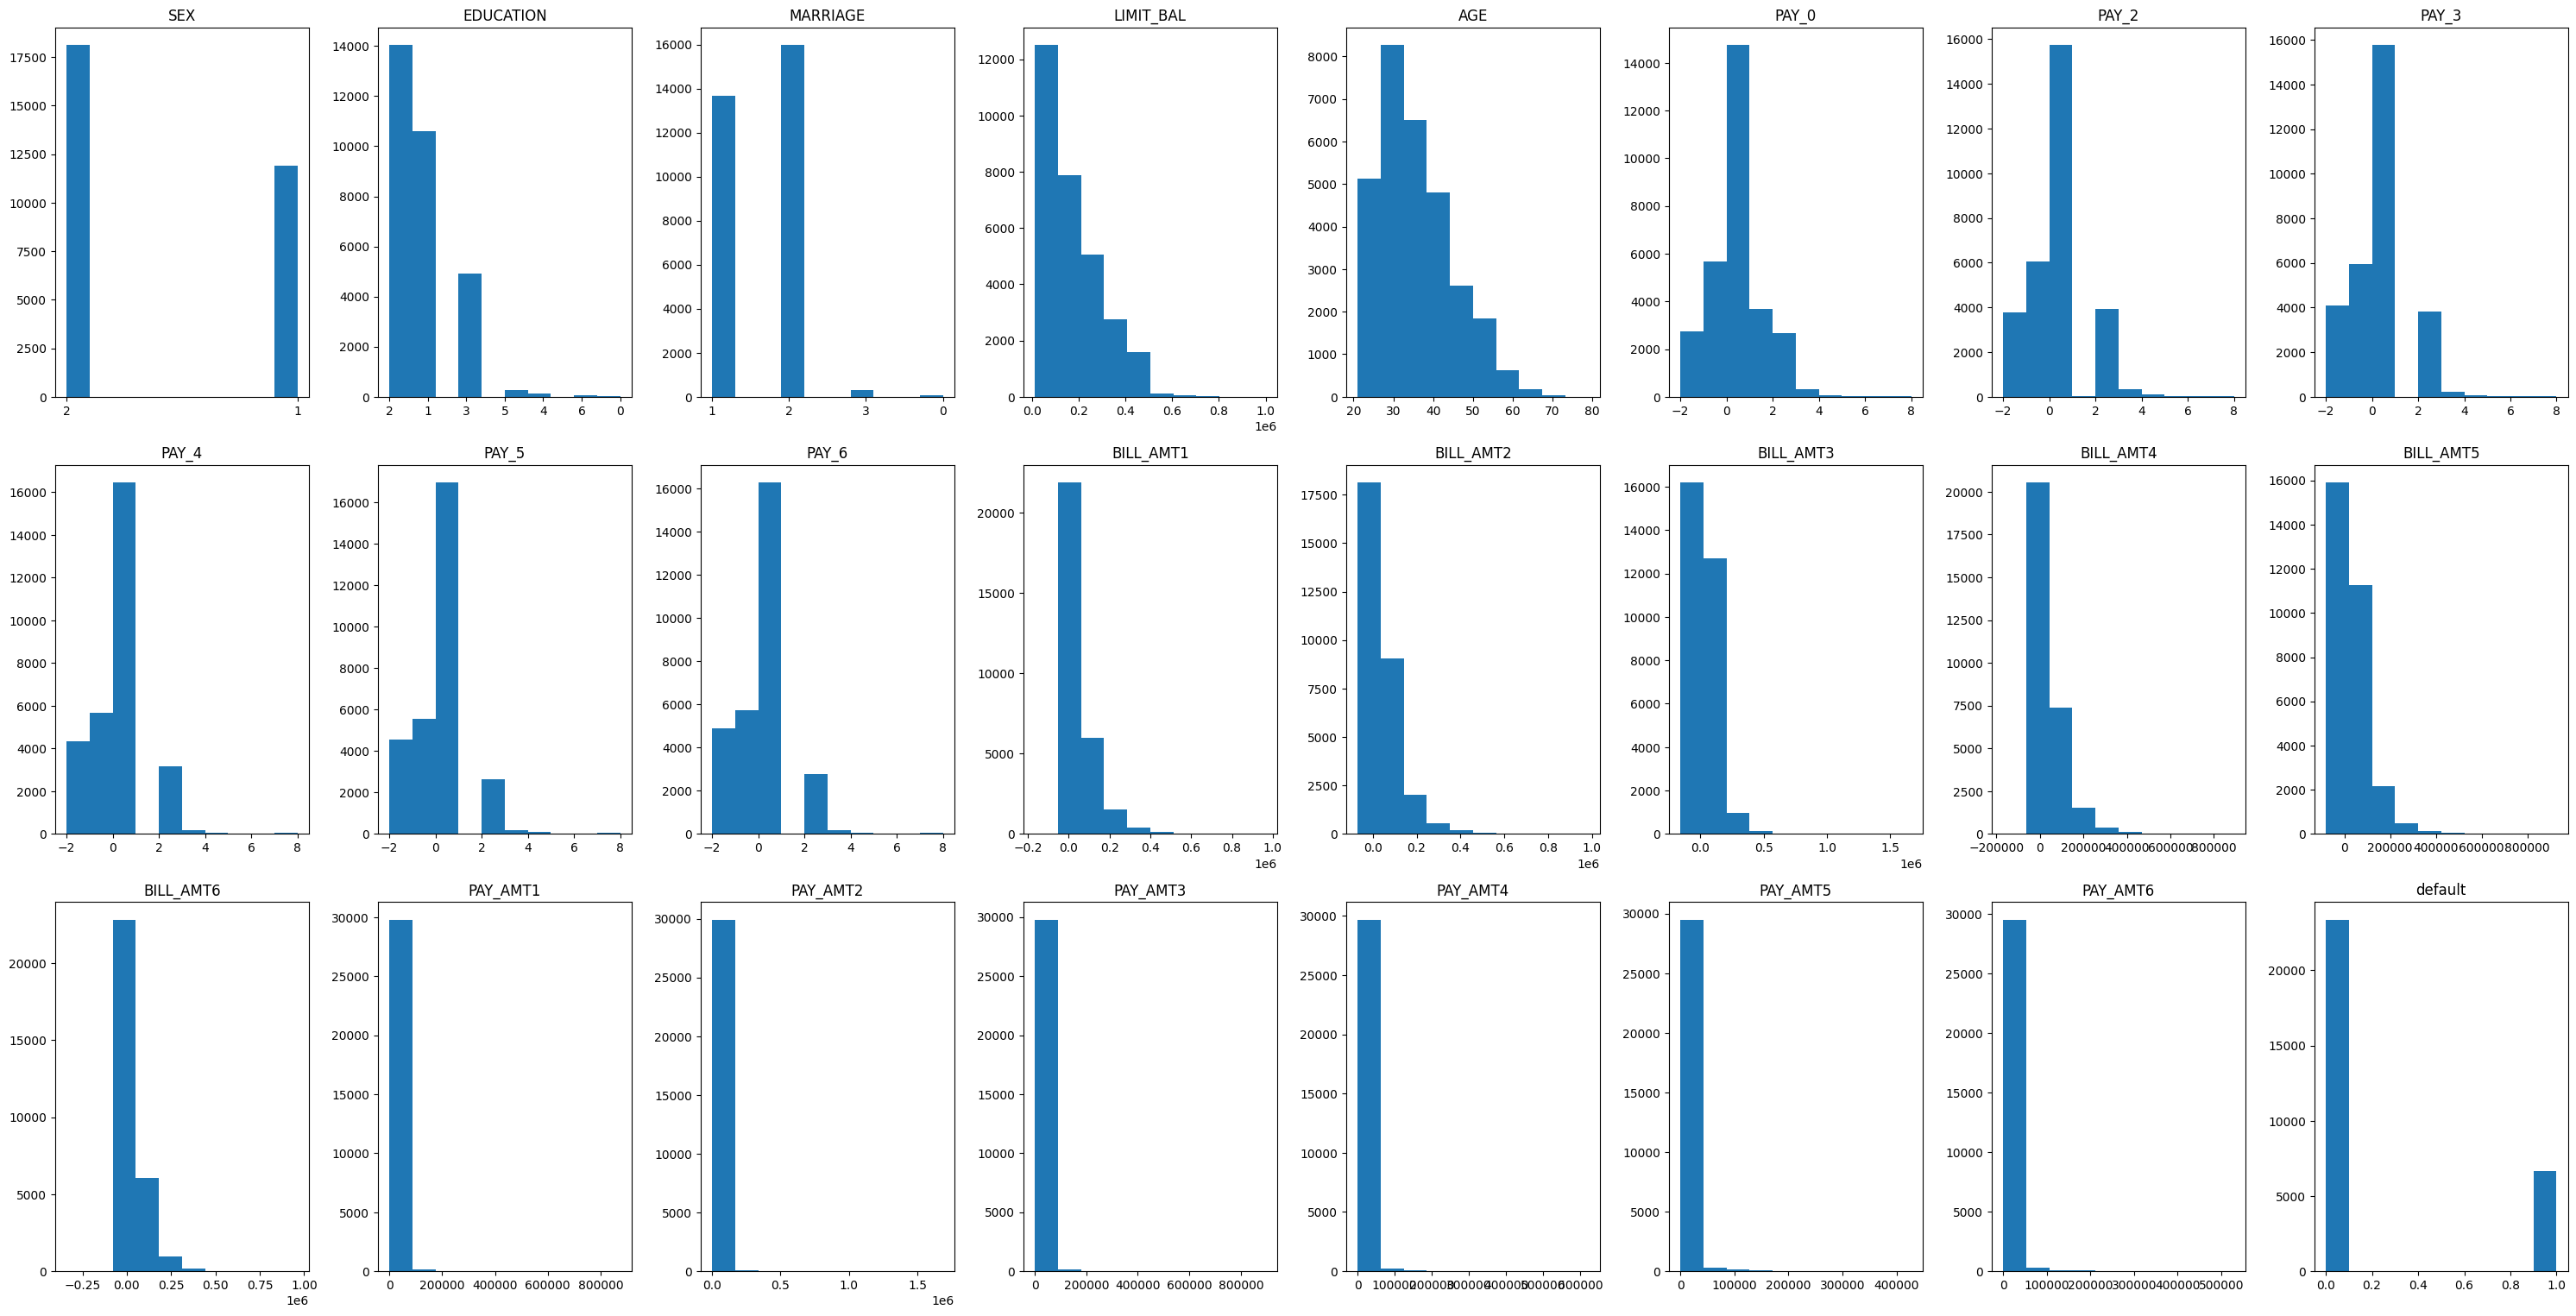

In [11]:
plt.figure(figsize=(30,20))
for ind,i in enumerate(df.columns):
    plt.subplot(4,8,ind+1)
    plt.title(i)
    plt.hist(i,data=df)
plt.tight_layout()
plt.show()

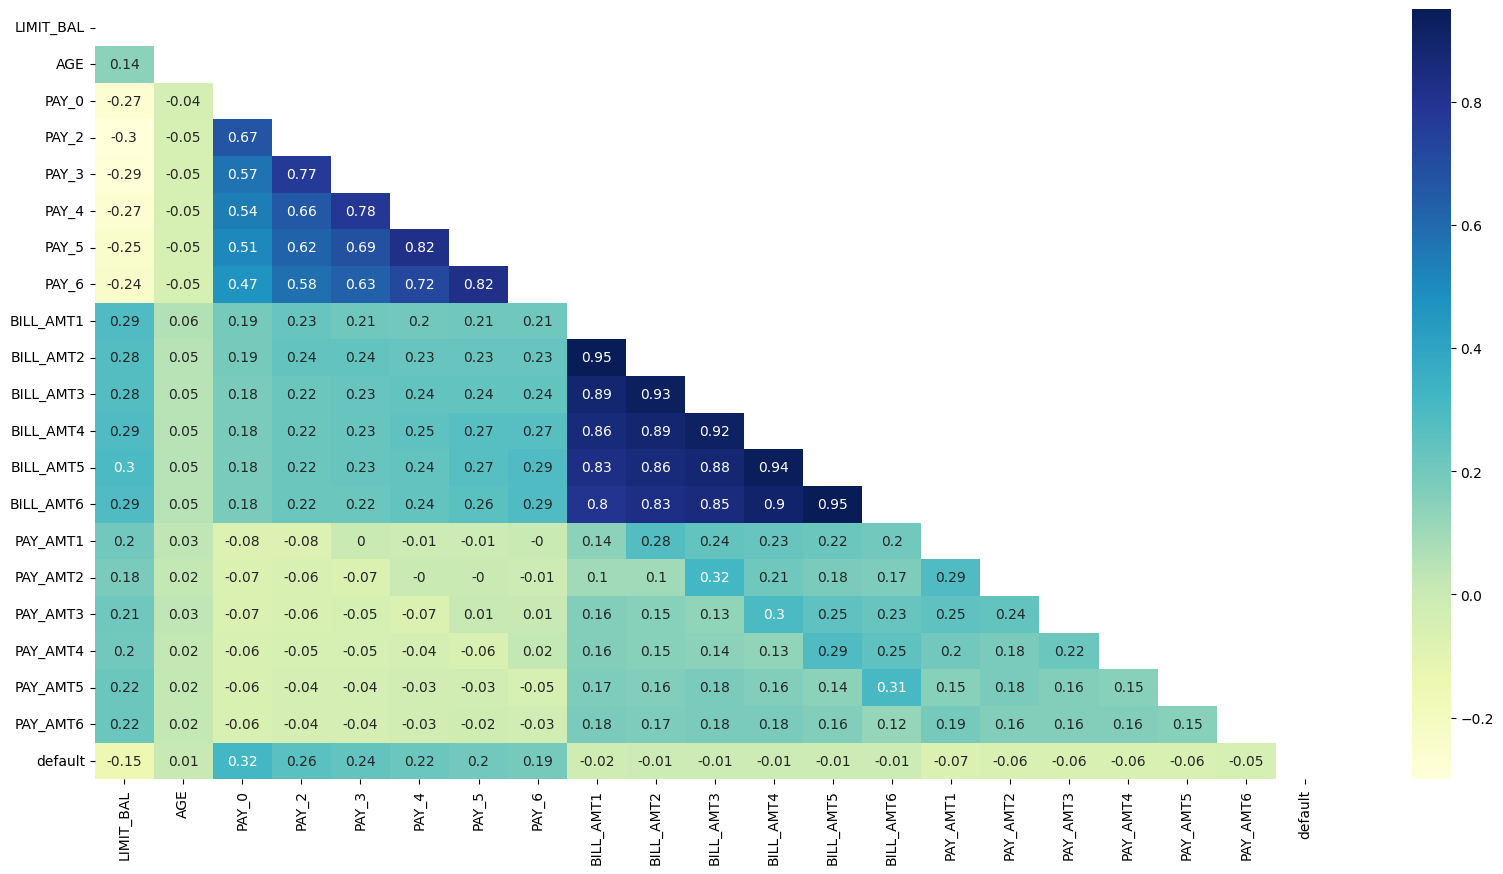

In [12]:
plt.figure(figsize=(20,10))
sns.heatmap(df[numeric_features + [target]].corr().round(2), cmap="YlGnBu", annot=True, mask = np.triu(np.ones_like(df[numeric_features + [target]].corr())))
plt.show()

### Feature Selection

#### Numeric Feature Selection Based on Variance

In [14]:
df[numeric_features].loc[:, df[numeric_features].var() > 0.9].columns.tolist()

['LIMIT_BAL',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

All numeric feature is selected since there is no feature with variance less than 0.9

#### Categoric Feature Selection Based on Chi Square

In [19]:
le = LabelEncoder()

_df = df.copy()

for feature in categorical_features:    
    _df[feature] = le.fit_transform(_df[feature])
_df['default'] = le.fit_transform(_df['default'])

X = _df[categorical_features]
y = _df['default']

selector = SelectKBest(score_func=chi2, k=3)
selector.fit(X, y)

feature_scores = selector.scores_
selected_features_indices = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_features_indices]

print("Chi-squared scores for each feature:", feature_scores)
print("Selected features:", selected_feature_names)

Chi-squared scores for each feature: [18.9833263   7.93125895  3.12000976]
Selected features: Index(['SEX', 'EDUCATION', 'MARRIAGE'], dtype='object')
